### Доклад - https://docs.google.com/document/d/183llNgZdidZfu8eItH__-Gr2i1aDLQlbsaGqOPvcVTU/edit

### Презентация - https://docs.google.com/presentation/d/1r8u_UV-NABlZrS1W7FOXZ-fO0pboEwEzfHf10gftBBg/edit#slide=id.p

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta, norm, invgamma

In [2]:
import matplotlib
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Генерируем группы А/Б-теста

In [30]:
df_ab = pd.DataFrame()

In [31]:
test_size = 5000

In [32]:
df_ab['ab_group'] = np.random.choice(['control', 'test'], size=test_size)

In [33]:
df_ab['conversion'] = np.random.choice([0, 1], size=test_size, p=[0.97, 0.03])

In [34]:
df_ab['revenue'] = 0

In [35]:
df_ab.loc[df_ab['conversion'] > 0, 'revenue'] = np.random.choice(
    [0.99, 1.99, 7.99, 29.99, 49.99],
    p=[0.7, 0.2, 0.05, 0.04, 0.01],
    size=df_ab['conversion'].sum()
)

In [36]:
df_ab.head(25)

,ab_group,conversion,revenue
0,control,0,0.0
1,control,0,0.0
2,test,0,0.0
3,test,0,0.0
4,control,0,0.0
5,control,0,0.0
6,test,0,0.0
7,test,0,0.0
8,control,0,0.0
9,control,0,0.0


### Конверсия в платящих

In [37]:
df_ab.groupby('ab_group')['conversion'].mean()

ab_group
control    0.024371
test       0.031638
Name: conversion, dtype: float64

### ARPU - средний чек игрока

In [38]:
df_ab.groupby('ab_group')['revenue'].mean()

ab_group
control    0.070072
test       0.121830
Name: revenue, dtype: float64

### ARPU = Conversion*ARPPU, где Conversion - распределение Бернулли, ARPPU - логнормальное

In [39]:
def BernulliDist(data, samples=10000):
    # data: pd.Series([0, 1, 0 ... 1, 0])
    # распределение средних Бернулли описывается бета распрелелением
    
    a = data.sum() + 0.5
    b = data.count() - data.sum() + 0.5
    
    return beta.rvs(a, b, size=samples)

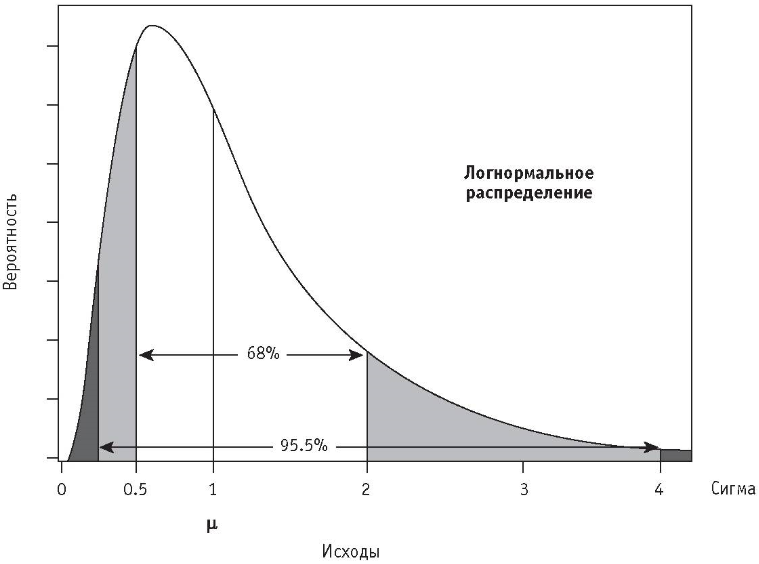

In [40]:
def LognormalDist(data, samples=10000):
    
    log_data = np.log(data)
    
    std = log_data.std()
    n = data.count()
    
    mu_mu = log_data.mean()
    mu_sigma = std / np.sqrt(n)
    
    var_alpha = (n - 1) / 2
    var_beta = var_alpha * std**2
    
    mu = norm.rvs(mu_mu, mu_sigma, size=samples)
    var = invgamma.rvs(var_alpha, scale=var_beta, size=samples)
    
    return np.exp(mu + var / 2)

In [41]:
def ARPUDist(data, samples=10000):
    conversion = BernulliDist((data > 0) * 1, samples)
    arppu = LognormalDist(data[data > 0], samples)
    
    return conversion * arppu

### Замеряем различие в группах по ARPU 

In [42]:
arpu_control = ARPUDist(df_ab[df_ab['ab_group'] == 'control']['revenue'], 100000)
arpu_test = ARPUDist(df_ab[df_ab['ab_group'] == 'test']['revenue'], 100000)

In [43]:
arpu_control.mean()

0.05089282973558058

In [44]:
arpu_test.mean()

0.08281299566513654

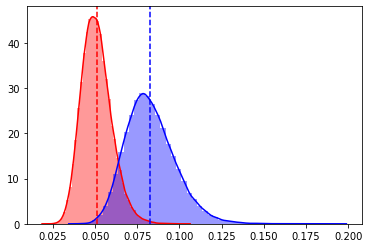

In [45]:
plt = sns.distplot(arpu_control, color='red')
plt = sns.distplot(arpu_test, color='blue')
plt.axvline(arpu_control.mean(), ls='--', c='red')
plt.axvline(arpu_test.mean(), ls='--', c='blue')

In [46]:
arpu_deltas = arpu_control - arpu_test

In [47]:
# вероятность того что победила контрольная
np.mean(arpu_deltas > 0)

0.02331

In [48]:
# вероятность того что победила тестовая
np.mean(arpu_deltas < 0)

0.97669

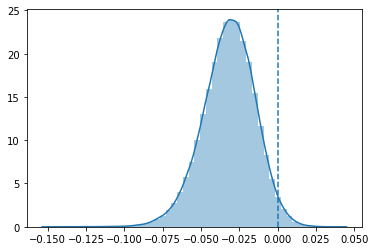

In [49]:
plt = sns.distplot(arpu_deltas)
plt.axvline(0, ls='--')

### Замеряем различие в группах по конверсии в платящих

In [50]:
conv_control = BernulliDist(df_ab[df_ab['ab_group'] == 'control']['conversion'])
conv_test = BernulliDist(df_ab[df_ab['ab_group'] == 'test']['conversion'])

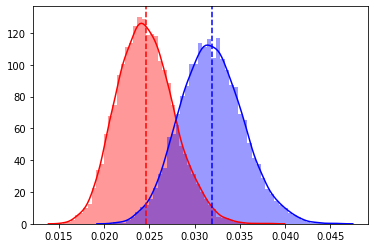

In [51]:
plt = sns.distplot(conv_control, color='red')
plt = sns.distplot(conv_test, color='blue')
plt.axvline(conv_control.mean(), ls='--', c='red')
plt.axvline(conv_test.mean(), ls='--', c='blue')

In [52]:
conv_deltas = conv_control - conv_test

In [53]:
np.mean(conv_deltas > 0)

0.0593

In [54]:
np.mean(conv_deltas < 0)

0.9407

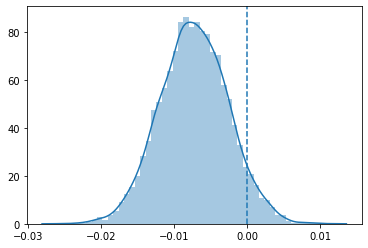

In [55]:
plt = sns.distplot(conv_deltas)
plt.axvline(0, ls='--')